# Предсказание оттока клиентов

📁 Kaggle: Telco Customer Churn

📊 Метрики: ROC AUC, Precision

🛠 Модель: Logistic Regression, CatBoost

🎁 Бонус: интерпретация с SHAP, таблица фичей с важностью

## 1. Первичная обработка и анализ датасета
- Загрузим датасет
- Первичный осмотр: .info(), .head()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/Telco_Customer_Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [12]:
print(f'Размер данных: {df.shape}')

Размер данных: (7043, 21)


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


## 2. Первичная статистика и отток (EDA)
- Распределение значения Churn
- Распределения по категориям: Contract, PaymentMethod, InternetService

In [13]:
df['Churn'].value_counts(normalize=True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

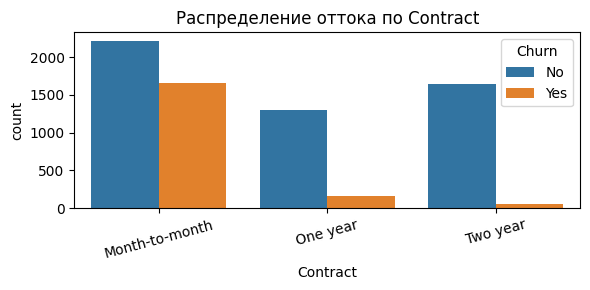

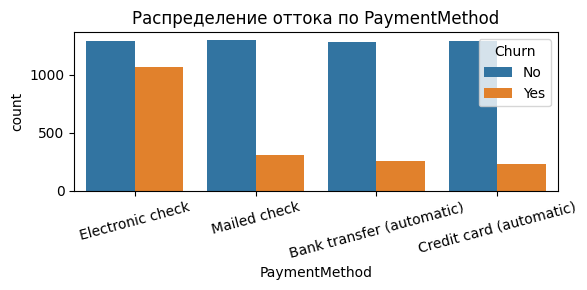

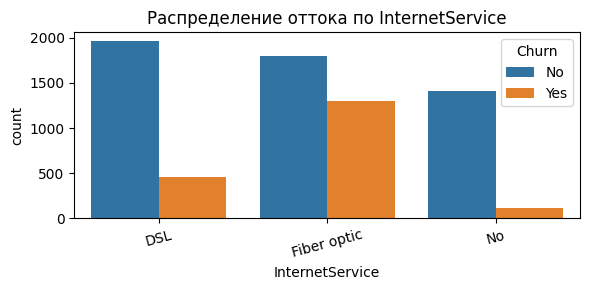

In [14]:
cat_features = ['Contract', 'PaymentMethod', 'InternetService']
for col in cat_features:
    plt.figure(figsize=(6, 3))
    sns.countplot(data=df, x=col, hue='Churn')
    plt.title(f"Распределение оттока по {col}")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

### Проверка и преобразование TotalCharges

In [16]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges']

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [17]:
print("Пропуски в TotalCharges:", df['TotalCharges'].isna().sum())

Пропуски в TotalCharges: 11


In [18]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

Приведем колонку SeniorCitizen к целочисленному типу данных (int).

In [20]:
df['SeniorCitizen'] = df['SeniorCitizen'].astype(int)

### Распределения числовых признаков

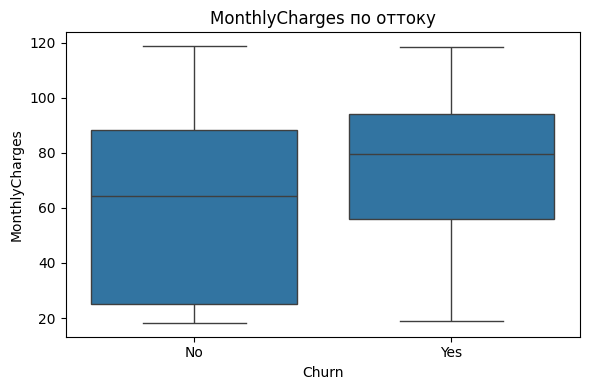

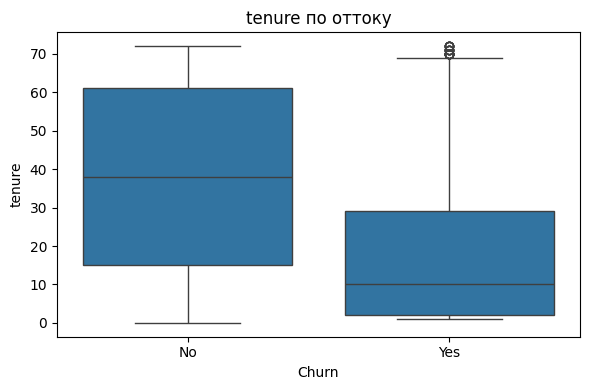

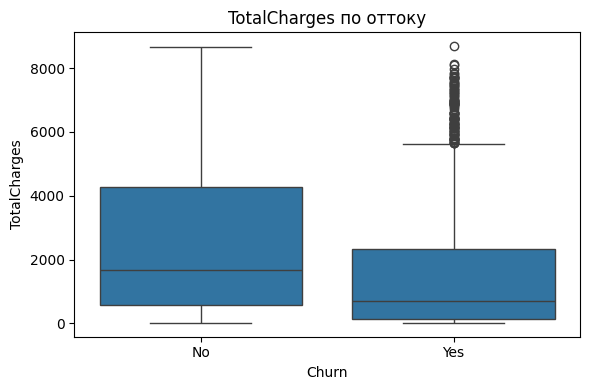

In [21]:
num_cols = ['MonthlyCharges', 'tenure', 'TotalCharges']
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x='Churn', y=col)
    plt.title(f"{col} по оттоку")
    plt.tight_layout()
    plt.show()

### Кореляция

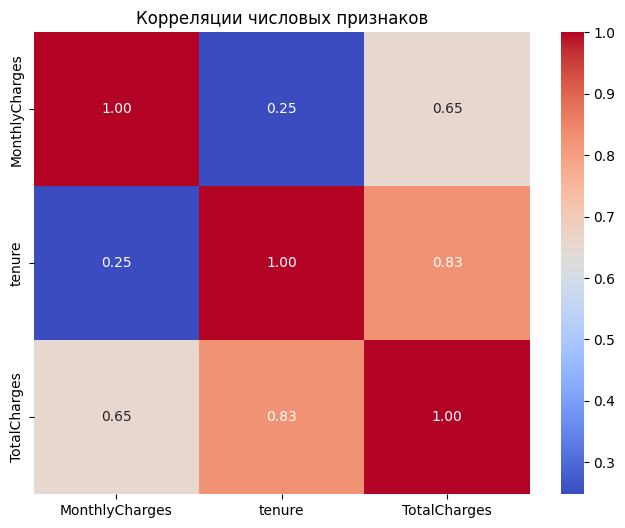

In [22]:
plt.figure(figsize=(8, 6))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Корреляции числовых признаков")
plt.show()

### Кодировка категориальных признаков

In [23]:
from sklearn.preprocessing import LabelEncoder

binary_cols = [col for col in df.columns if df[col].nunique() == 2 and df[col].dtype == 'object']
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

In [24]:
df = pd.get_dummies(df, drop_first=True)

### Примеры новых признаков

In [25]:
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 60, 72],
                             labels=['0–12','12–24','24–48','48–60','60+'])
df = pd.get_dummies(df, columns=['tenure_group'], drop_first=True)

Смотрим, если ли стриминг

In [27]:
df['HasStreaming'] = df[['StreamingTV_Yes', 'StreamingMovies_Yes']].sum(axis=1) > 0
df[['HasStreaming']]

,HasStreaming
0,False
1,False
2,False
3,False
4,False
...,...
7038,True
7039,True
7040,False
7041,False


In [28]:
print("Финальный shape:", df.shape)
df.head()

Финальный shape: (7043, 7078)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_12–24,tenure_group_24–48,tenure_group_48–60,tenure_group_60+,HasStreaming
0,0,0,1,0,1,0,1,29.85,29.85,0,...,False,False,False,True,False,False,False,False,False,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,True,False,False,False,True,False,True,False,False,False
2,1,0,0,0,2,1,1,53.85,108.15,1,...,False,False,False,False,True,False,False,False,False,False
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,True,False,False,False,False,False,True,False,False,False
4,0,0,0,0,2,1,1,70.70,151.65,1,...,False,False,False,True,False,False,False,False,False,False


In [29]:
df.to_csv("data/telco_processed.csv", index=False)